In [1]:
from scipy.io import loadmat
import numpy as np
import pandas as pd
from scipy.ndimage import uniform_filter1d
from pathlib import Path

from skvideo.io import vread, vwrite
from PIL import ImageDraw, Image

import matplotlib.pylab as plt
from matplotlib import colors


In [2]:
p_avi =Path(r'../right_left/starved-bb.avi')
p_mat =Path(r'../right_left/starved-bb/starved-bb-track.mat')

thresh_stop, thresh_walk = 5, 5
thresh_vel = 0.25

20
61
54
55
86


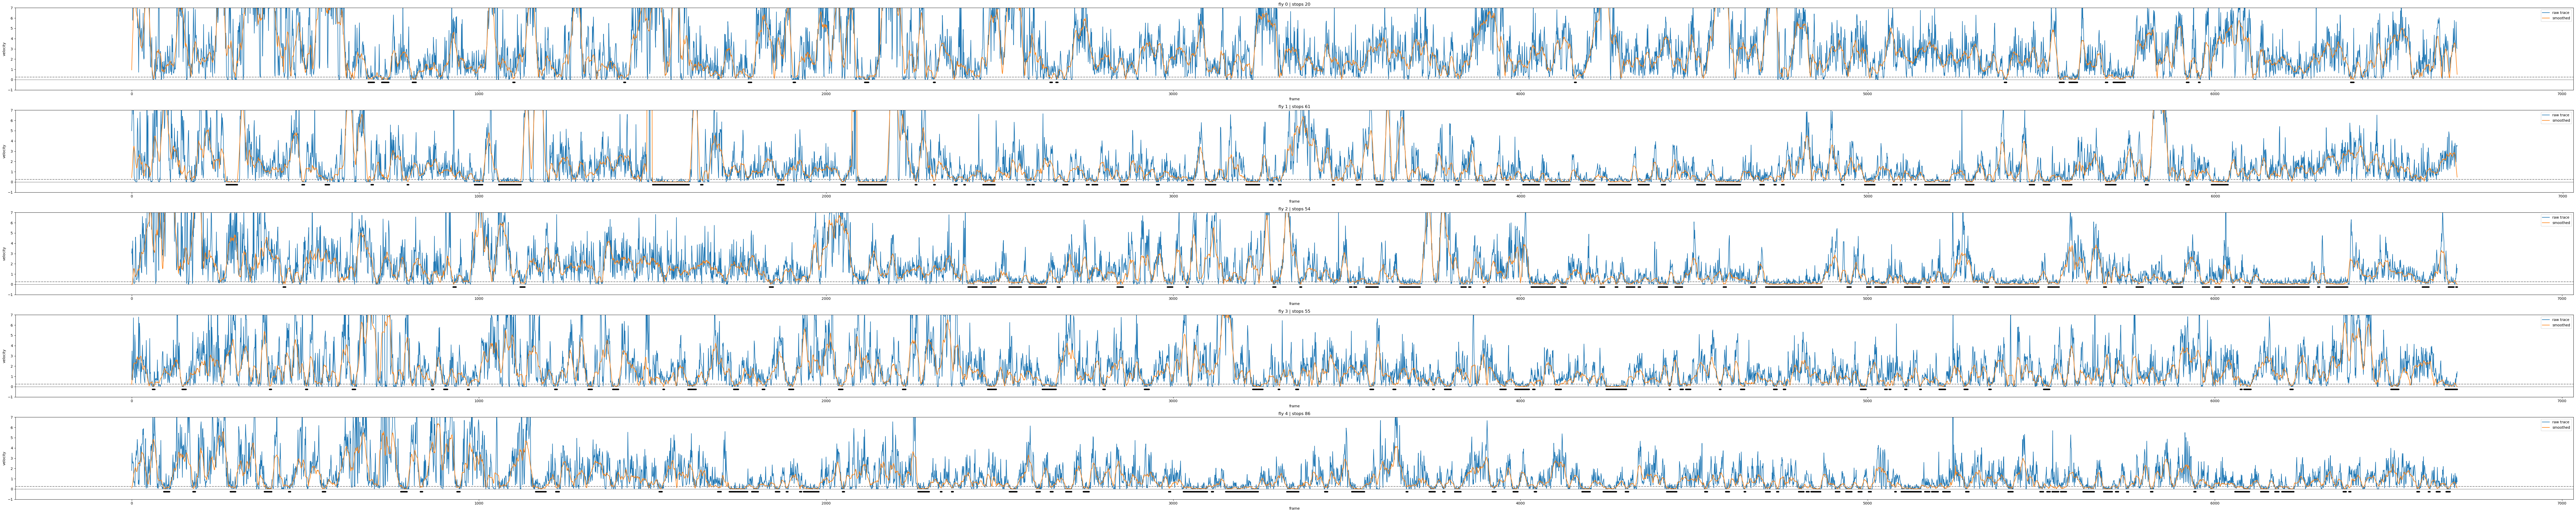

In [3]:
vid = vread(str(p_avi))
m = loadmat(p_mat, squeeze_me=True, struct_as_record=False)
data = vars(m['trk'])['data'][:, :, [0, 1]]

p_avi_annot = p_avi.parent / '{}_annot.avi'.format(p_avi.with_suffix('').name)
p_png = p_avi.parent / '{}_vel_stop.png'.format(p_avi.with_suffix('').name)

fig, axarr = plt.subplots(nrows=len(data), figsize=(100, 4*len(data)))

number = True

for i, (ax, d) in enumerate(zip(axarr, data)):
    rgb = tuple([int(f*255) for f in colors.to_rgb('C{}'.format(i))])

    fnan = np.isnan(d).any(axis=1)

    d = d[~fnan]
    vel = np.linalg.norm(np.diff(d, axis=0), axis=1)
    ax.plot(vel, c='C0', label='raw trace')

    vel = np.linalg.norm(np.diff(uniform_filter1d(d, 15, axis=0), axis=0), axis=1)
    ax.plot(vel, c='C1', label='smoothed')
    
    stop = pd.Series(vel < thresh_vel)
    # cycle through stop and walk periods
    split = np.split(stop, np.flatnonzero(np.diff(stop)) + 1)
    for s in split:
        # if walk periods are shorter than thresh_walk, set them to stop
        if not s.sum() and (len(s) < thresh_walk):
            stop.loc[s.index] = True

    # redefine periods and cylce again
    split = np.split(stop, np.flatnonzero(np.diff(stop)) + 1)
    for s in split:
        # if stop intervals are shorter than thresh_stop, set them to walk
        if s.sum() and (len(s) < thresh_stop):
            stop.loc[s.index] = False

    # count stops and write to video
    split = np.split(stop, np.flatnonzero(np.diff(stop)) + 1)
    n_stop = 0
    for s in split:
        if s.sum():
            n_stop += 1

            for f in s.index:
                x, y = d[f].astype(int)
                
                if number:
                    img = Image.fromarray(vid[f])
                    draw = ImageDraw.Draw(img)
                    draw.text((x, y), str(n_stop), rgb)
                    vid[f] = np.array(img)
                else: 
                    w = 3
                    vid[f, y-w:y+w, x-w:x+w, :] = rgb

    print(n_stop)
 

    x = stop.index[stop]
    y = np.zeros_like(x) - 0.25
    ax.scatter(x, y, marker='.', color='k')

    ax.axhline(thresh_vel, c='gray', ls='--')

    ax.axhline(0, c='k', lw=0.5)
    ax.set_xlabel('frame')
    ax.set_ylabel('velocity')
    ax.set_ylim(-1, 7)
    # ax.set_xlim(0, 500)
    ax.set_title('fly {} | stops {}'.format(i, n_stop))
    ax.legend()

fig.tight_layout()
fig.savefig(p_png)

# write
vwrite(str(p_avi_annot), vid, inputdict={'-framerate': '30'})